<a href="https://colab.research.google.com/github/rikurzt/Finacial_analyze_course_HW/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A_HW5_7113029027%E6%9D%8E%E5%86%A0%E5%BB%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用統計套利(配對交易)交易台積電2330與元大證券0050

資料前處理

In [83]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt


In [84]:
def call_twse_api(stock_id=2330, year=2024, month=9):
  """Calls the TWSE API to retrieve stock data for a specific month."""
  url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={year}{month:02}01&stockNo={stock_id}"
  try:
    response = requests.get(url)
    response.raise_for_status()
    return response.json()
  except requests.exceptions.RequestException as e:
    print(f"Error calling API: {e}")
    return None

In [85]:
def get_stock_data(stock_id, start_year, end_year):
  """Retrieves stock data for a given stock ID within a year range."""
  all_data = []
  for year in range(start_year, end_year + 1):
    for month in range(1, 13):
      data = call_twse_api(stock_id, year, month)
      if data and 'data' in data:
        all_data.extend(data['data'])
  return all_data

In [92]:
stock_data_A = get_stock_data('2330', start_year =2023, end_year = 2023)
stock_data_B = get_stock_data('0050', start_year =2023, end_year = 2023)

df_A = pd.DataFrame(stock_data_A, columns=['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數'])
df_B = pd.DataFrame(stock_data_B, columns=['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數'])

In [87]:
df_A

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,112/01/03,"10,763,824","1,180,641,220",105.00,111.00,105.00,111.00,+4.50,"7,421"
1,112/01/04,"6,803,117","755,763,775",110.00,112.00,109.00,112.00,+1.00,"5,381"
2,112/01/05,"8,664,821","969,301,428",112.50,114.50,109.50,110.50,-1.50,"6,894"
3,112/01/06,"4,863,800","543,770,495",110.50,113.50,110.50,112.00,+1.50,"3,852"
4,112/01/09,"6,729,708","762,588,977",113.50,114.50,112.00,113.50,+1.50,"4,584"
...,...,...,...,...,...,...,...,...,...
234,112/12/25,"8,727,380","2,294,673,390",260.00,264.50,259.50,263.50,+4.50,"9,580"
235,112/12/26,"7,776,642","2,046,534,012",264.50,264.50,261.00,264.00,+0.50,"17,841"
236,112/12/27,"9,387,800","2,476,684,321",265.50,266.00,261.00,264.00,0.00,"8,163"
237,112/12/28,"7,942,383","2,110,827,266",265.50,267.50,264.00,265.50,+1.50,"8,392"


In [88]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib


matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-17 10:30:46--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 209.85.145.101, 209.85.145.138, 209.85.145.139, ...
Connecting to drive.google.com (drive.google.com)|209.85.145.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-17 10:30:46--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   108MB/s    in 0.2s    

2024-10-17 10:30:

## 統計套利

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

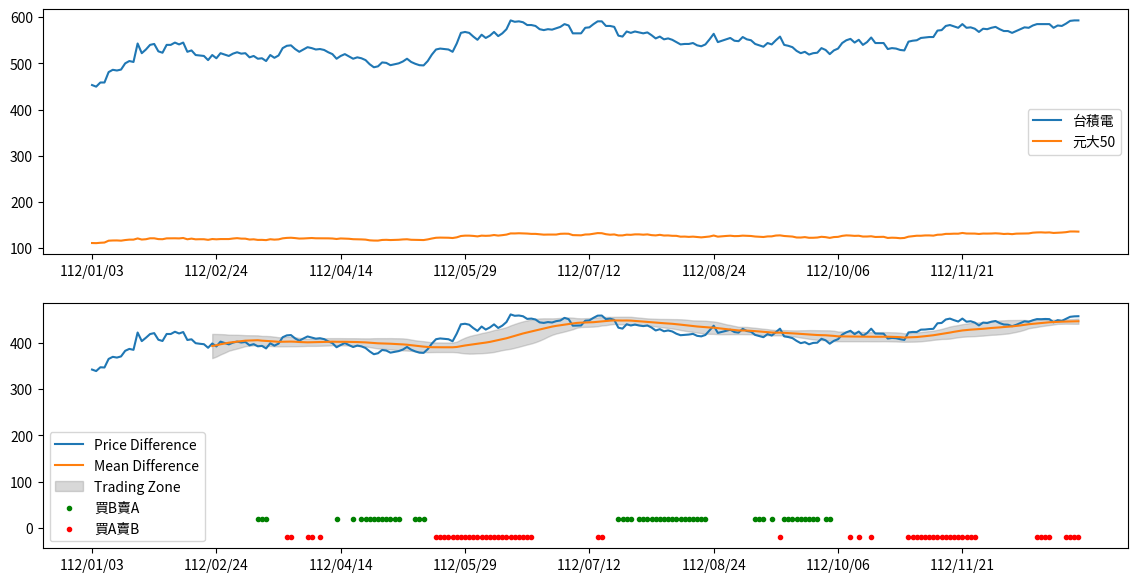

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.DataFrame({
    'Date': df_A['日期'],
    'Stock_A': pd.to_numeric(df_A['收盤價'], errors='coerce'),
    'Stock_B': pd.to_numeric(df_B['收盤價'], errors='coerce')
})
data.set_index('Date', inplace=True)
# 計算股票價差
data['Price_Diff'] = data['Stock_A'] - data['Stock_B']
# 計算價差的移動平均與標準差
window = 30
data['Mean_Diff'] = data['Price_Diff'].rolling(window=window).mean()
data['Std_Diff'] = data['Price_Diff'].rolling(window=window).std()
# 設置買入買出預值
data['Upper_Bound'] = data['Mean_Diff'] + data['Std_Diff']
data['Lower_Bound'] = data['Mean_Diff'] - data['Std_Diff']

# 生成交易信號

data['Position'] = 0
data.loc[data['Price_Diff'] > data['Upper_Bound'], 'Position'] = -1  #價差>upper bond，做空A股，做多B股
data.loc[data['Price_Diff'] < data['Lower_Bound'], 'Position'] = 1   #價差<lower bond，做多A股，做空B股

# 繪製圖表

plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(data['Stock_A'], label='台積電')
plt.plot(data['Stock_B'], label='元大50')
plt.xticks(df_A.get('日期')[::30],rotation=0)
plt.legend()
plt.subplot(212)
plt.plot(data['Price_Diff'], label='Price Difference')
plt.plot(data['Mean_Diff'], label='Mean Difference')
plt.fill_between(data.index, data['Upper_Bound'], data['Lower_Bound'], color='gray', alpha=0.3, label='Trading Zone')
plt.scatter(data.index[data['Position'] == 1], data['Position'][data['Position'] == 1] * 20, color='green', marker='.', label='買B賣A')
plt.scatter(data.index[data['Position'] == -1], data['Position'][data['Position'] == -1] * 20, color='red', marker='.', label='買A賣B')


plt.xticks(df_A.get('日期')[::30],rotation=0)
plt.legend()
plt.show()

In [91]:
data['Position'].value_counts()

,count
Position,
0,108
1,77
-1,54
